In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm


import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchmetrics

from PIL import Image    


# Preprocessing
This is where we preprocess the data

### Load in data from directories

#### Trying to do zero padding

In [5]:
# Get the max height and width of dataset
paths = pd.read_csv("train_images.csv")

max_w = 0
max_h = 0
for i in paths.index:
    # The dot makes it so that it's relative to your current dir,
    curr_path = paths["image_path"][i]
    rgb_img = Image.open("." + curr_path).convert('RGB')

    h = np.shape(rgb_img)[0]
    w = np.shape(rgb_img)[1]

    if (h > max_h):
        max_h = h
    if (w > max_w):
        max_w = w

max_h = max_h
max_w = max_w
print("max H: ", max_h)    
print("max W: ", max_w)



max H:  500
max W:  500


In [6]:
# loading in and storing train to a vector
# can't store it in numpy array due to diff in dimensionality
paths = pd.read_csv("train_images.csv")

X = np.zeros((3926, 500, 500, 3), dtype=np.uint8)

for i in paths.index:
    # The dot makes it so that it's relative to your current dir,
    curr_path = paths["image_path"][i]
    rgb_img = Image.open("." + curr_path).convert('RGB')
    rgb_img = np.array(rgb_img)
    
    # calculate the amount of padding
    h = np.shape(rgb_img)[0]
    w = np.shape(rgb_img)[1]

    # print("h", h)
    # print("w", w)

    pad_left = (max_w - w) // 2
    pad_right = max_w - w - pad_left

    pad_up = (max_h - h) // 2
    pad_down = max_h - h - pad_up

    # print("left", pad_left)
    # print("right", pad_right)
    # print("up", pad_up)
    # print("down", pad_down)

    # Actually perform the padding
    rgb_img = np.pad(rgb_img, pad_width=((pad_up, pad_down), (pad_left, pad_right), (0,0)))

    # # calculate the amount of padding
    # h = np.shape(rgb_img)[0]
    # print("h", h)
    # w = np.shape(rgb_img)[1]
    # print("w", w)

    # pad_left = (max_w - w) // 2
    # pad_right = max_w - w - pad_left

    # pad_up = (max_h - h) // 2
    # pad_down = max_h - h - pad_up

    # print("left", pad_left)
    # print("right", pad_right)
    # print("up", pad_up)
    # print("down", pad_down)
    # plt.imshow(rgb_img)

    X[i] = rgb_img

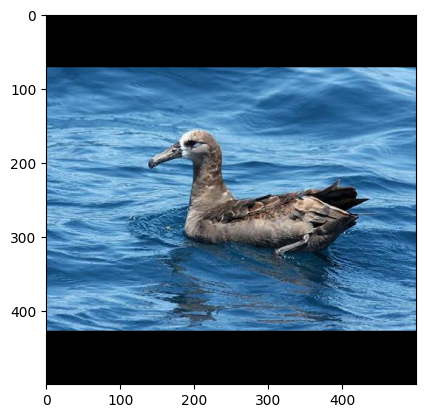

In [7]:
np.shape(X)
plt.imshow(X[0])

### Resize version of preprocessing

In [ ]:
# loading in and storing train to a vector
# can't store it in numpy array due to diff in dimensionality
paths = pd.read_csv("train_images.csv")

X = []
for i in paths.index:
    # The dot makes it so that it's relative to your current dir,
    curr_path = paths["image_path"][i]
    rgb_img = Image.open("." + curr_path).convert('RGB')

    # Resize to 256, 256
    width = np.shape(rgb_img)[0]
    height = np.shape(rgb_img)[1]

    if width == height:
        rgb_img = rgb_img.resize((256,256))
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            rgb_img = rgb_img.crop((left,top,right,bottom))
            rgb_img = rgb_img.resize((256,256))
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            rgb_img = rgb_img.crop((left,top,right,bottom))
            rgb_img = rgb_img.resize((256,256))
    
    X.append(rgb_img)

X = np.array(X)

In [ ]:

Y = paths["label"]
Y

In [ ]:
# testing out if this matches nicely
index = 35
plt.imshow(X[index])
print(Y[index])

### Some exploration of the data

In [ ]:
# temp 

data = pd.read_csv("/Users/micolcandoni/Documents/GitHub/AppliedMLProject/aml-2025-feathers-in-focus/train_images.csv")

data.head(10)

In [ ]:
print(data.size)

In [ ]:
from collections import Counter


#count how many images per label 

counts_labels = data['label'].value_counts().sort_index().reset_index()
counts_labels.columns = ['Label', 'Count']


for i in counts_labels.iterrows():
    print(i[1])

In [ ]:
print(counts_labels)

In [ ]:
print(counts_labels['Label'].head())

In [ ]:
#viualise counts in a plot

import matplotlib.pyplot as plt

plt.figure(figsize = (15, 4))
plt.bar(counts_labels['Label'], counts_labels['Count'], color = 'violet')
plt.title("Number of Images per Bird Class")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

In [ ]:
data['label'].value_counts().head()      # Most common

In [ ]:
data['label'].value_counts().tail()      # Least common

### Make sure all data is in the same size

In [ ]:
# check CNN

## Data Augmentation

In [ ]:
data_copy = data.copy()

> Creating a validation set (from train_images.csv)

In [1]:
from sklearn.model_selection import train_test_split

train_data, validate_data = train_test_split(
    data,
    test_size=0.2,
    stratify= data['label'],
    #to ensure that each bird class is represented fairly in both splits
    random_state= 42
)

train_data.to_csv("train_split.csv", index=False)
validate_data.to_csv("validate_split.csv", index=False)


KeyboardInterrupt



In [ ]:
print(train_data.head())

In [ ]:
print(validate_data.head())

In [ ]:
print(train_data.size)
print(validate_data.size)

> Printed to make sure that the dataset was correctly split (and to see what it looks like).

- Full dataset size: 7852
- Train set size: 6280
- Validate set size: 1572

> Now I will compute some Basic Image Data Augmentations on my train set, specifically Image Manipulation (ex:rotation, translation, shearing, flipping, cropping, noise injection, and colour space).

> According to the paper, things to look out for are: overly aggressive transformations (as this can risk confusing the model), mixing across classes to create ambiguous images, and overfitting (by relying too much on augmentations). 

In [ ]:
train_set = pd.read_csv("train_split.csv")

augmentation_output = "augmented_set"
os.makedirs(augmentation_output, exist_ok=True)

new_rows = []



def rotate(img, degrees = 15):
    return img.rotate(degrees)
#rotate the image by 15 degrees


def flip(img):
    return img.transpose(Image.FLIP_LEFT_RIGHT)
#flip image horizontally


def brighten(img, factor = 1.3):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)
#increase brightness


def addnoise(img, amount = 10):
    array = np.array(img).astype(np.int16)
    noise = np.random.randint(-amount, amount, array.shape)
    array = np.clip(array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(array)
#add random noise (small)


def translate(img, shiftx = 15, shifty = 10):
    return img.transform(
        img.size, 
        Image.AFFINE,
        (1, 0, shiftx, 0, 1, shifty),
        resample = Image.BICUBIC,
        fillcolor = (0, 0, 0)
    )
#do translations (shift the image slightly as shown in the paper)


#create dictionary:
augmentations = {
    "rotate": lambda img: rotate(img, 15),
    "flip": lambda img: flip(img),
    "brighten": lambda img: brighten(img, 1.3),
    "noise": lambda img: addnoise(img),
    "translate": lambda img: translate(img, 15, 10)
}



#applying the 5 augmentation techniques to create new images (increase dataset size)

for index, row, in train_set.iterrows():
    image_path = row["image_path"].lstrip("/")
    label = row["label"]
    image = Image.open(image_path).convert("RGB")

    base_name = os.path.basename(image_path)
    name, extension = os.path.splitext(base_name)


    for augmented_name, augmented_function in augmentations.items():
        augmented_image = augmented_function(image)
        newfile = f"{name}_{augmented_name}{extension}"
        newpath = f"{augmentation_output}/{newfile}"

        augmented_image.save(newpath)

        new_rows.append({
            "image_path": newpath,
            "label": label
        })



#combining the original images + new rows to create bigger dataset

augmenteddf = pd.DataFrame(new_rows)
newdf = pd.concat([train_set, augmenteddf], ignore_index=True)

newdf.to_csv("train_augmented.csv", index=False)

In [ ]:
print(newdf.head())
print(newdf.size)

> printed to see what my new df looks like. Size is 37680, which confirms that augmentations worked correctly. 

>Initial amount = 6280 x 5 = 31400 + 6280 (original) = 37680

In [ ]:
df = pd.read_csv("train_augmented.csv")

# Remove leading slash ONLY 
df["image_path"] = df["image_path"].str.lstrip("/")

df.to_csv("train_augmented.csv", index=False)

> Now I can randomly select a picture and generate the augmentations to see how the augmentations look like compared to the original. Every time I run, a new image will be selected. 

In [ ]:
import random

df = pd.read_csv("train_augmented.csv")

#Pick a random ORIGINAL image from train_set only (not from augmented_set)
df_original_only = df[df["image_path"].str.contains("train_images")]
random_row = df_original_only.sample(1).iloc[0]

orig_path = random_row["image_path"]
label = random_row["label"]

#Extract base name (ex: "1250")
base_name = os.path.splitext(os.path.basename(orig_path))[0]

#Build expected augmented filenames
aug_folder = "augmented_set"
aug_versions = {
    "rotate": f"{aug_folder}/{base_name}_rotate.jpg",
    "flip": f"{aug_folder}/{base_name}_flip.jpg",
    "brighten": f"{aug_folder}/{base_name}_brighten.jpg",
    "noise": f"{aug_folder}/{base_name}_noise.jpg",
    "translate": f"{aug_folder}/{base_name}_translate.jpg"
}

#Load images
images = {"original": Image.open(orig_path).convert("RGB")}
for aug_name, path in aug_versions.items():
    if os.path.exists(path):
        images[aug_name] = Image.open(path).convert("RGB")
        

plt.figure(figsize=(15, 8))
columns = len(images)
for i, (title, img) in enumerate(images.items(), start=1):
    plt.subplot(1, columns, i)
    plt.imshow(img)
    plt.title(title, fontsize=12)
    plt.axis("off")

plt.suptitle(f"Label: {label} — Base image: {base_name}", fontsize=14)
plt.show()

In [ ]:
print(newdf.head())

In [ ]:
from collections import Counter


#count how many images per label 

counts_labels_new = newdf['label'].value_counts().sort_index().reset_index()
counts_labels.columns = ['Label', 'Count']


for i in counts_labels.iterrows():
    print(i[1])

In [ ]:
#viualise counts in a plot

import matplotlib.pyplot as plt

plt.figure(figsize = (15, 4))
plt.bar(counts_labels_new['label'], counts_labels_new['count'], color = 'lightblue')
plt.title("Number of Images per Bird Class")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

# Training models

### Downloaded model

In [ ]:
# temp

### Simple model

In [8]:
image_shape = (3, 500, 500)

cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1),  # keeps 500x500
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2),  # → 250×250

    nn.Dropout(0.2),

    nn.Flatten(),  # flatten to 3 * 250 * 250

    nn.Linear(3 * 250 * 250, 32),
    nn.ReLU(),

    nn.Linear(32, 10),
    nn.Softmax(dim=1)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [ ]:
df = pd.read_csv("train_augmented.csv")

# Remove leading slash ONLY 
df["image_path"] = df["image_path"].str.lstrip("/")

df.to_csv("train_augmented.csv", index=False)

> Now I can randomly select a picture and generate the augmentations to see how the augmentations look like compared to the original. Every time I run, a new image will be selected. 

In [ ]:
print(model)

: 

### Complex model (enseble methods)

In [ ]:
#temp

# Comparing models
Here we need to decide what metric to use in order to compare them.

In [ ]:
# temp